In [271]:
import pickle
# ^^^ pyforest auto-imports - don't write above this line
import pyforest

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as pt
import seaborn

from scipy.stats import chi2_contingency, shapiro, mannwhitneyu, ttest_ind,levene, f_oneway #oneway pour anova
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
import warnings
import os

warnings.filterwarnings("ignore")

- Jeu de données disponible sur : https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster

# Plan : 

#### 1. Connaissance du jeu de données 
- Présence d'une target ?
- Features signification
- Dimensions des données
- Type de données et cohérence (variables discrètes : int, continues : float, qualitative : str)

#### 2. imputation des données :
- NaN présent : vrai NaN ou signifie une absence d'élément ?
- Variables numériques :
    - discrètes : remplacement par le mode 
    - continues : moyenne ou médiane en fonction des outliers
    
#### 3. Analyse univariée

#### 4. Analyse bivariée & test statistiques
- Target vs features catégorique (discrètes + qualitatives) : 
- Target vs features continues : boxplot & mise en place des tests si nécessaire (test normalité )  
- Target vs features catégorique : discrètes + qualitatives


#### 5. Analyse multivariée
- Analyse des features continues via heatmap
- Analyse des variables corrélées et anticorrélées avec scatterplot

#### 6. Preprocessing
- Standardisation des données
- Encodage des données


In [272]:
path = os.getcwd()

In [273]:
split_path = path.split("\\")[:-1]

In [274]:
path_data = '\\'.join(split_path)
path_data

'D:\\Etude_Data_science\\Kaggle_competition\\03_Multi-Class Prediction of Obesity Risk'

In [275]:
path_df = path_data+"\\dataset\\"

In [276]:
os.listdir(path_df)

['final_df.csv', 'test.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip']

# 1. Connaissance du jeu de données 


In [277]:
data = pd.read_csv(path_df+"train.csv")
df = data.copy()

In [278]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [279]:
print(f" Nombre de lignes : {df.shape[0]} \n Nombre de colonnes : {df.shape[1]}")

 Nombre de lignes : 20758 
 Nombre de colonnes : 18


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [281]:
df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


#### Pour chaque feature, regardons le nombre de valeur totale prise par la colonne,  son type de données et  quelques valeurs :

In [282]:
print("Nom variables : nombre de valeurs prise (type de variable)")
print("\n")
for i in df.select_dtypes(exclude="object"):
    col = df[i]
    print(f"{i:-<30} : {col.nunique()}  ({col.dtypes})")
    print(col.unique()[:5])
    print()

Nom variables : nombre de valeurs prise (type de variable)


id---------------------------- : 20758  (int64)
[0 1 2 3 4]

Age--------------------------- : 1703  (float64)
[24.443011 18.       20.952737 31.641081 18.128249]

Height------------------------ : 1833  (float64)
[1.699998 1.56     1.71146  1.71073  1.914186]

Weight------------------------ : 1979  (float64)
[ 81.66995   57.        50.165754 131.274851  93.798055]

FCVC-------------------------- : 934  (float64)
[2.       1.880534 3.       2.679664 2.919751]

NCP--------------------------- : 689  (float64)
[2.983297 3.       1.411685 1.971472 2.164839]

CH2O-------------------------- : 1506  (float64)
[2.763573 2.       1.910378 1.674061 1.979848]

FAF--------------------------- : 1360  (float64)
[0.       1.       0.866045 1.467863 1.967973]

TUE--------------------------- : 1297  (float64)
[0.976473 1.       1.673584 0.780199 0.931721]



- Toutes les features ici prennent beaucoup de valeur différentes (>500) et sont des float, excepté l'id mais ceci est normal
- il n'y a pas de variable discrète

In [283]:
print("Nom variables : nombre de valeurs prise (type de variable)\n")
print()
for i in df.select_dtypes(include="object"):
    col = df[i]
    print(f"{i:-<30} : {col.nunique()}  ({col.dtypes})")
    print(col.unique()[:5])
    print()

Nom variables : nombre de valeurs prise (type de variable)


Gender------------------------ : 2  (object)
['Male' 'Female']

family_history_with_overweight : 2  (object)
['yes' 'no']

FAVC-------------------------- : 2  (object)
['yes' 'no']

CAEC-------------------------- : 4  (object)
['Sometimes' 'Frequently' 'no' 'Always']

SMOKE------------------------- : 2  (object)
['no' 'yes']

SCC--------------------------- : 2  (object)
['no' 'yes']

CALC-------------------------- : 3  (object)
['Sometimes' 'no' 'Frequently']

MTRANS------------------------ : 5  (object)
['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']

NObeyesdad-------------------- : 7  (object)
['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II']



Les features ici sont uniquement de type object (qualitative), on a beaucoup de variables binaires, 3 features ordinales et une features nominal (MTRANS)

#### Récupération des différentes features en fonction de leur dtype :

In [284]:
#Séparer les variables en fonction de leur type facilitera les analyse statistiques que nous établierons ultérieurement
var_cont = list(df.select_dtypes(exclude="object").columns)
var_qual =  list(df.select_dtypes(include="object").columns)
var_nom = ["MTRANS"]
var_ord = [i for i in df.select_dtypes("object") if i not in var_nom ]

## Informations fournies avec le jeu de données : 

### Target : 
Présence d'une target multiclasse = **classification**
Target multiclasse : **NObesity** pouvant prendre les valeurs suivantes : 
- **Underweight** : < 18.5
- **Normal** : 18.5 to 24.9
- **Overweight** :25.0 to 29.9
- **Obesity I** : 30.0 to 34.9
- **Obesity II** : 35.0 to 39.9
- **Obesity III** : > 40


### Features : 

- **FAVC** = Consommation fréquente d'aliments riches en calories
- **FCVC** = Fréquence de la consommation de légumes 
- **NCP** =Nombre de repas principaux
- **CAEC**  = Consommation d'aliments entre les repas 
- **CH20**  = Consommation d'eau quotidienne
- **CALC** = Consommation d'alcool

Concernant les attributs physiques : 
- **SCC** = Suivi de la consommation de calories
- **FAF** = Fréquence de l'activité physique
- **TUE** = Temps d'utilisation des appareils technologiques
- **MTRANS** = Moyen transport utilisé


## 2. imputation des données 

In [285]:
df.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

Pas de données manquantes

### 3.  Analyse univariée :
- En fonction du type de données nous allons procéder à des visualisation différentes
- Tout d'abord, regardons la répartition de la target 

#### Analyse de la target :

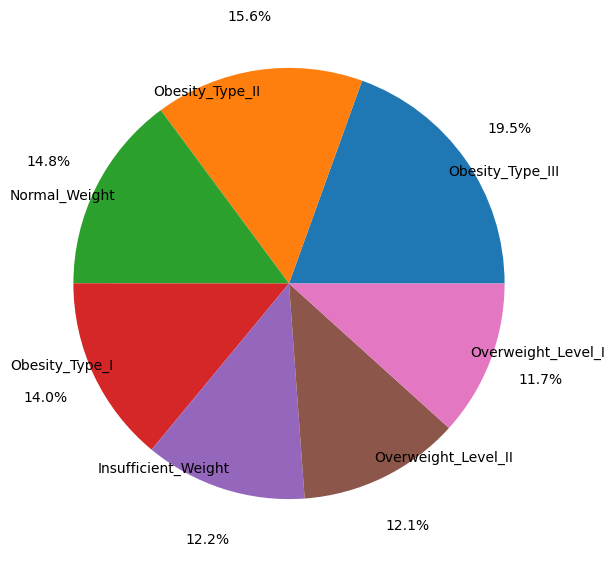

In [286]:
value_count_target = df.NObeyesdad.value_counts()
sizes,labels = value_count_target.values, value_count_target.index
fig, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=0.9)
plt.show()

#### Observation : 
- Les données sont a peu près équilibré, on peut voir qu'il y a une majorité atteint de forme d'obésité la plus sévère (type III), on peut aussi noté que dans le jeu de données, nous avons aussi des patients atteint de maigreur (insufficient weight)

#### Variables continues : 
- Affichons la distribution et un boxplot pour chacune de ces variables

In [287]:
def distribution_plot(columns):
#     columns = str(columns)
    fig, axes = plt.subplots(1,2, figsize=(10,4))



    dist = sns.distplot(a = df[str(columns)] , kde_kws={"color":"red"}, hist_kws = {"color":"orange"}, ax=axes[0])
    axes[0].axvline(df[columns].mean(), color='red', ls=':', label="Mean", )
    axes[0].axvline(df[columns].median(), color = "slateblue", ls="--", label = "Median")
    axes[0].legend()

    boxplot = sns.boxplot(y=columns , data=df[var_cont], color="orange", ax=axes[1],
                          showmeans=True,meanprops={"marker": "o", "markeredgecolor": "yellow", 
                                                    "markerfacecolor":"red",
                                                    "markersize": "10", "label":"mean"} )
    axes[1].legend()
    plt.show()

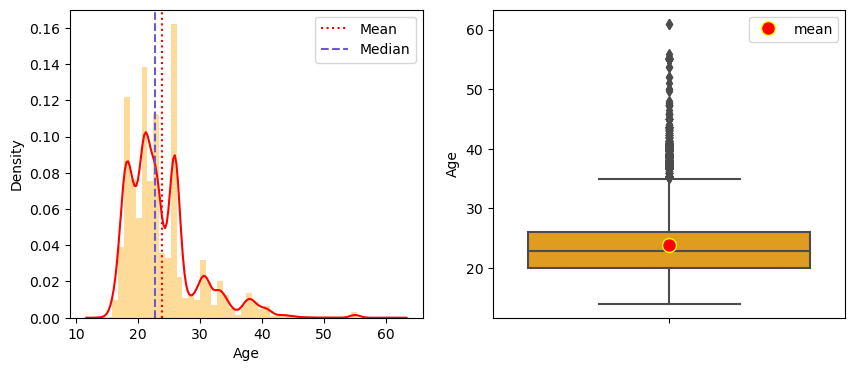

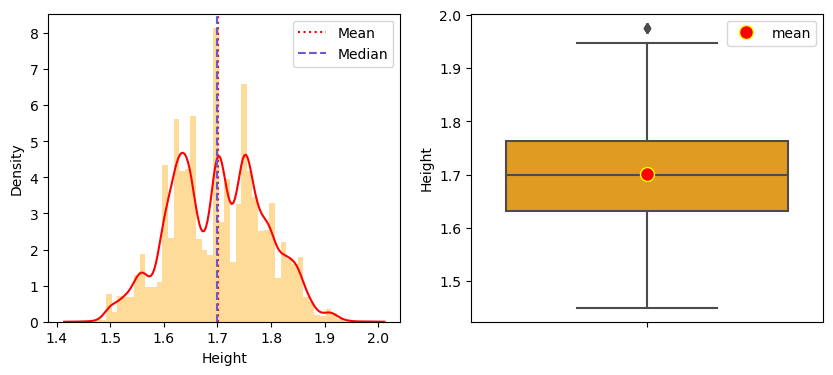

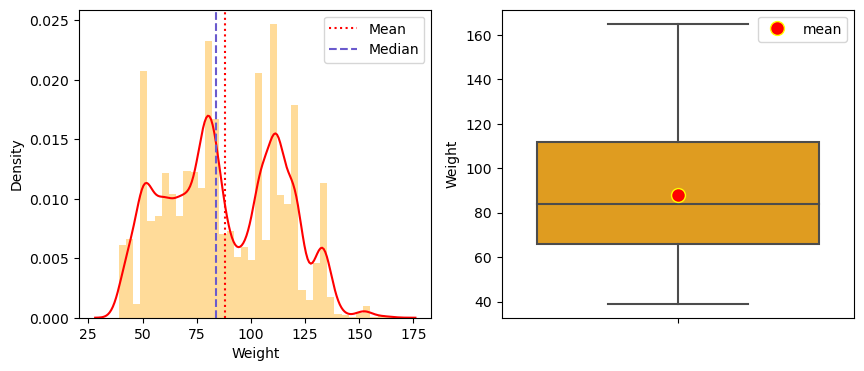

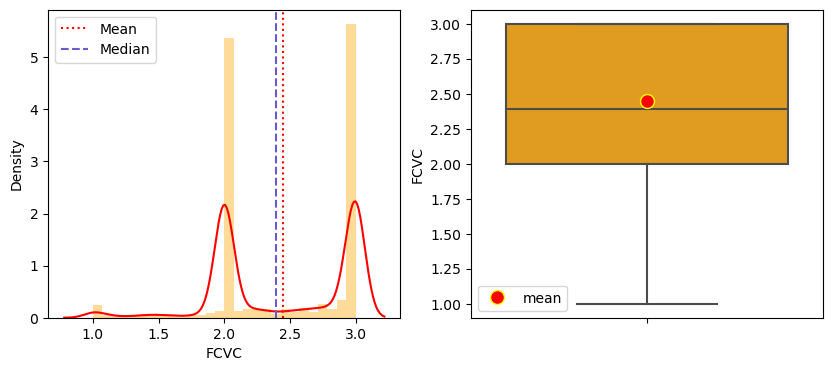

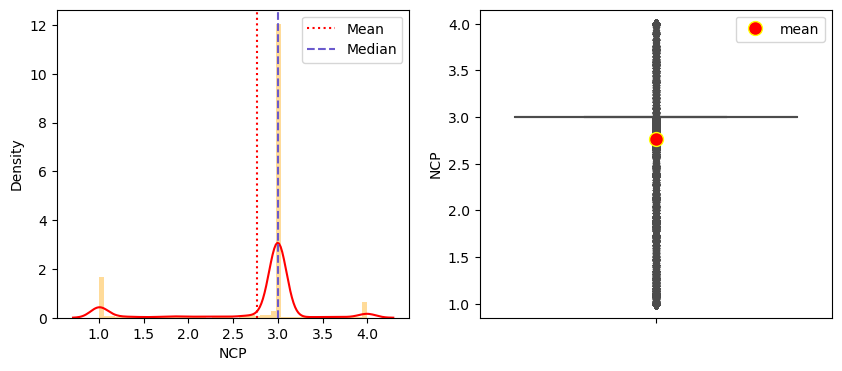

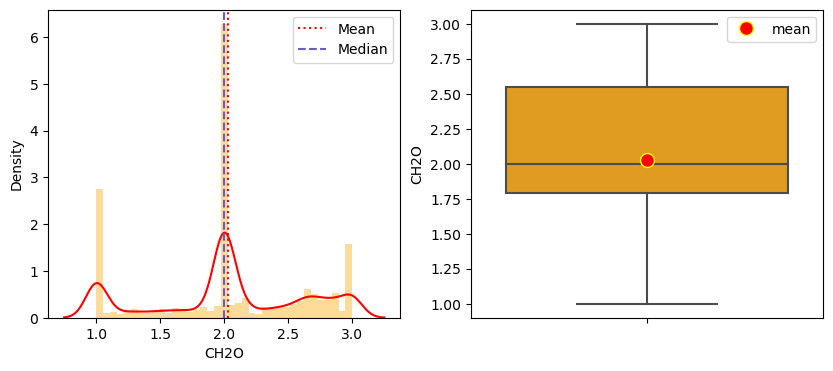

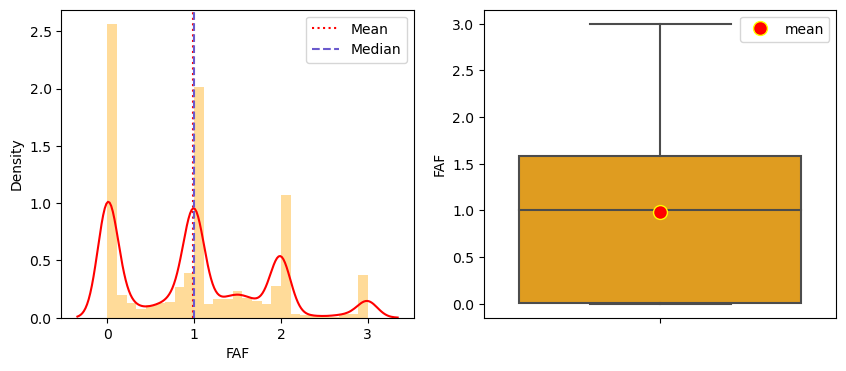

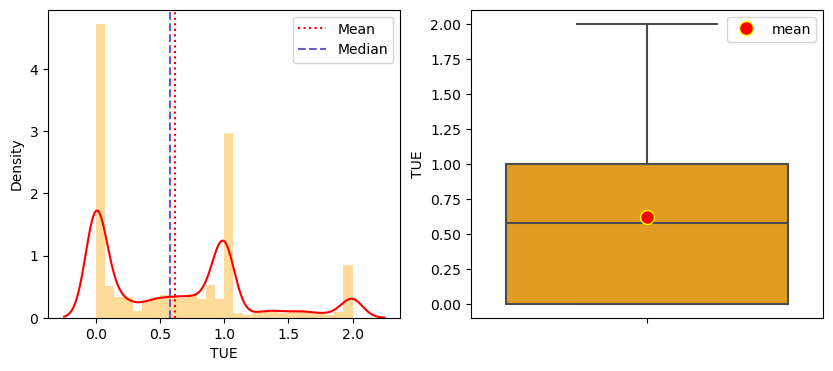

In [288]:
for i in var_cont:
    if i!="id":
        distribution_plot(i)

#### Observation :
- **Age** = age moyen 25 ans, donc population plutôt jeune, avec des individus jusqu'à 60 ans
- **Height** = taille moyenne  1.7m
- **Weight** = poids moyen 77kg
- **FCVC** = Consommation legume 2 à 3 fois
- **NCP** = un ou trois repas, on peut noter ici le boxplot qui est constitué que d'outliers
- **CH20** =  consommation d'eau  2 fois
- **FAF** = Beaucoup n'ont pas d'activité physique
- **TUE** = Temps d'utilisation d'écran est de 0.6 (unité?)



* Au vu de la distribution, on peut supposer que certaines features sont en réalité des variables discrètes : 
    - FCVC, NCP, CH20, FAF et TUE
On va transformer ces variables en variables discrètes en arrondissant leur valeur et en changeant leur dtypes :

- Les variables continues, ne semblent pas suivre une loi normale, on voit que la distribution n'est pas caractéristique des courbes qui suivent une loi normale

#### variables discrètes :

In [289]:
var_dis = ["FCVC", "NCP", "CH2O", "FAF", "TUE"]
#Arrondir les valeurs :
df[var_dis] = df[var_dis].apply(lambda x:round(x))

#Convertir les colonnes en int :
df = df.astype({col: int for col in var_dis})

In [290]:
# En parallèle on peut retirer les variables qu'on considère discrètes de var_cont
var_cont = [i for i in var_cont if i not in var_dis]

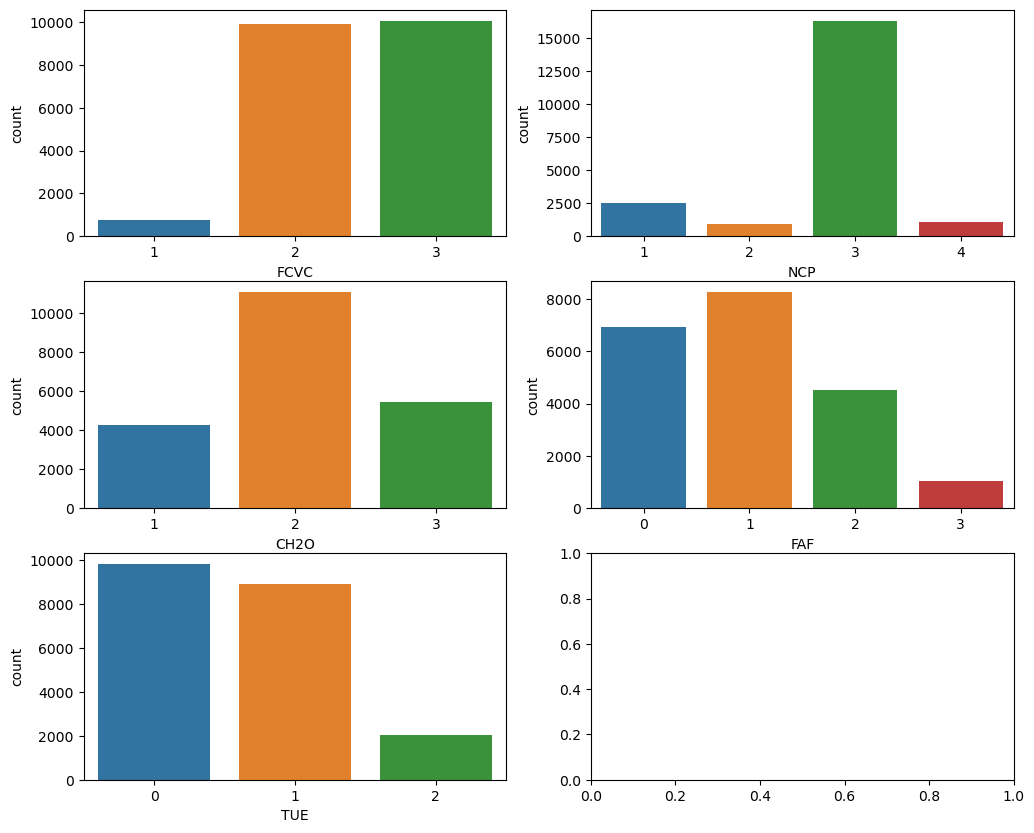

In [291]:
fig, axes = plt.subplots(3,2, figsize=(12,10))
for i,k in enumerate(var_dis):
    nrow,ncols = i//2, i%2
    sns.countplot(x = k, data = df, ax= axes[nrow,ncols])
plt.show()

#### variables qualitatives 

In [292]:
def countplot_vis(ligne,colonne, variables):
    """fonction qui renvoie un countplot, on définit le nombre de lignes et de colonnes pour obtenir
    le bon nombre de figure """
    fig, axes = plt.subplots(ligne,colonne, figsize=(22,20))
    for i,k in enumerate(variables):
        nrow,ncols = i//3, i%3
        ax=sns.countplot(x = k, data = df, ax= axes[nrow,ncols])
        ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    plt.show()

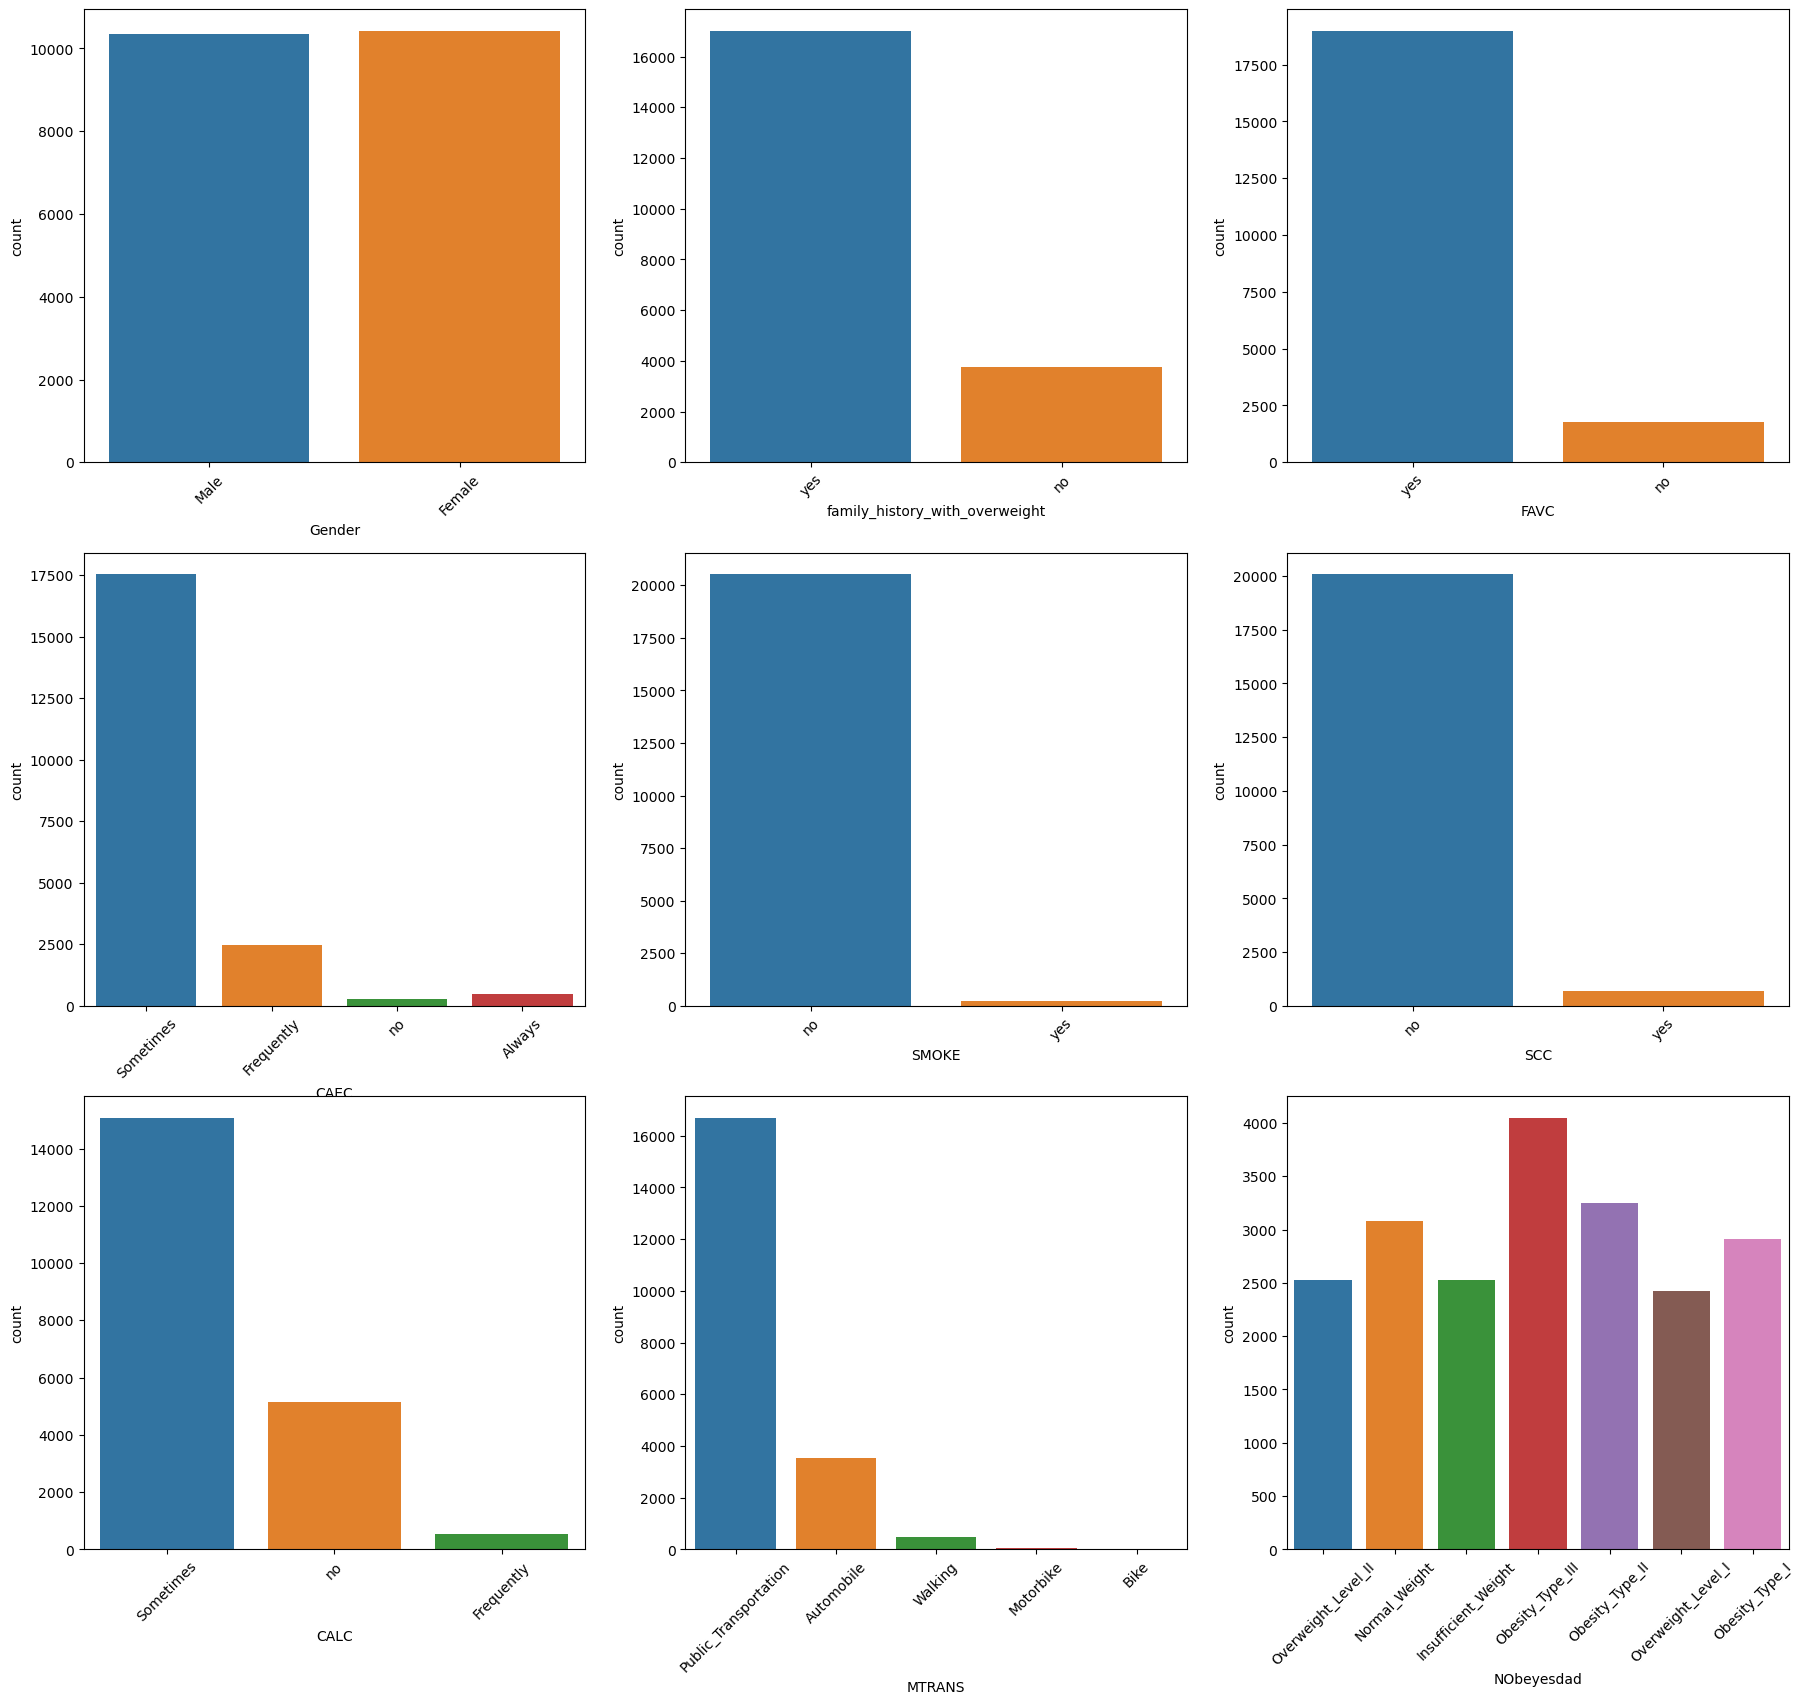

In [293]:
countplot_vis(3,3,var_qual)

#### Observations :
- **Gender** : données équilibrée autant de femme que d'homme dans l'étude
- **family_history_with_overweight** : beaucoup d'antécédant de surpoids dans les familles
- **FAVC** : majorité de personne consommant beaucoup de calories
- **CAEC** : une grande majorité mange temps en temps entre les repas
- **SMOKE** : très peu de fumeur
- **SCC** : pas de suivi de la consommation en calories
- **CALC** : beaucoup consomme un peu d'alcool, environs un tier ne bois pas
- **MTRANS** : transport en commun en majorité
- **NObeyesdad** : la target est assez équilibré, les obèses de type III sont les plus représentés

### Conclusion des analyse de variables :
Nous avons une population qui, globalement, ne fait pas trop d'activité physique, manges beaucoup, ou les problemes de surpoids sont présent, aussi bien dans la famille que pour les personnes selectionnés, la majorité est légèrement en surpoids (1m70 pour 77kg) chez une population qui est plutôt jeune.

## 4. Analyse bivariée & test statistiques
#### Target vs features catégorique (discrètes + qualitatives) : 


Récupération des variables discrètes et qualitatives dans var_cat :

In [294]:
var_cat = var_dis+var_qual

In [295]:
def khi2(data, target, var_qualitative):
    # Test de Student pour comparer les moyennes des autres variables
    df_temp = pd.crosstab(index=data[target],columns= data[var_qualitative])
    p_val = chi2_contingency(df_temp)[1]
    alpha = 0.05
    
    print(f"Test khi2 :  \n{var_qualitative} \np-value = {p_val.round(3)}")

    if p_val < alpha:
        print("p-value ≤ α , il y a une différence/corrélation entre les populations.")
        print()
    else:
        print("p-value ≥ α , il n’y a pas de différence/relation entre les populations de l’étude.")
        print()
        #Si c'est cette condition qui ait rempli, alors la variable ne sera pas conservée et sera supprimée
        return  var_qualitative

In [296]:
for i in var_cat:
    khi2(df, 'NObeyesdad', i)

Test khi2 :  
FCVC 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
NCP 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
CH2O 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
FAF 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
TUE 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
Gender 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
family_history_with_overweight 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
FAVC 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
CAEC 
p-value = 0.0
p-value ≤ α , il y a une différence/corrélation entre les populations.

Test khi2 :  
SMOKE 


**On comprend ici que toutes les variables catégoriques semblent être pertinentes pour notre target**

#### Target Vs  variables continues :

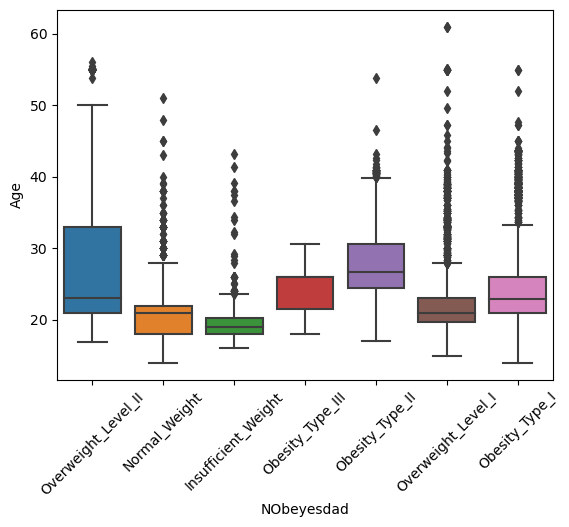

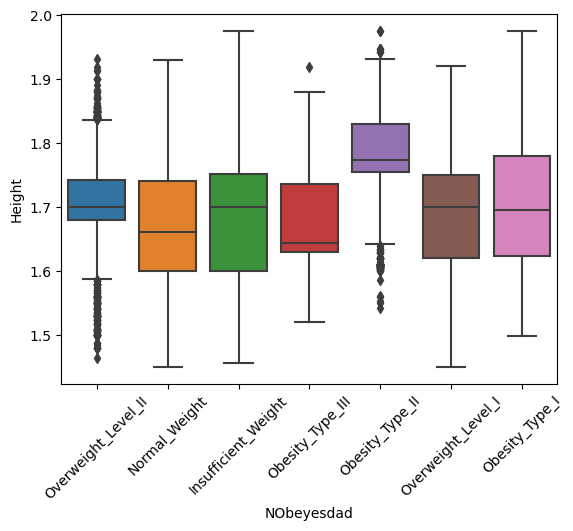

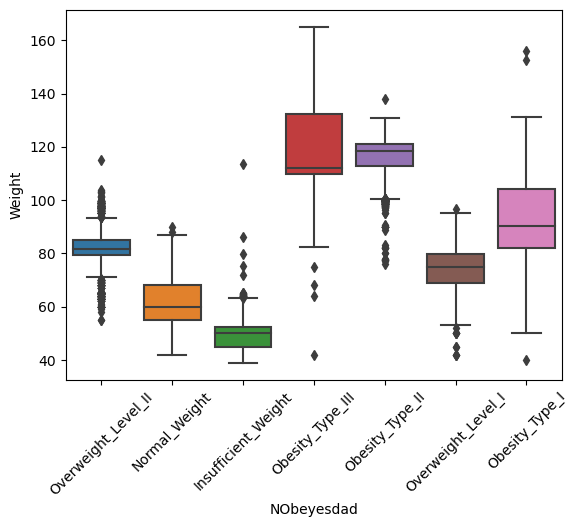

In [297]:
for i in var_cont:
    if i !="id":
        ax = sns.boxplot(y=i, x = "NObeyesdad", data = df)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
        plt.show()

* Visuellement on aperçoit une variation des médiane pour chaque features en fonction de la valeur prise par la target, donc il y a de forte chance qu'il y ait une dépendance features - target
- Pour en être plus sûr, nous allons effectuer un test statistique : **ANOVA**


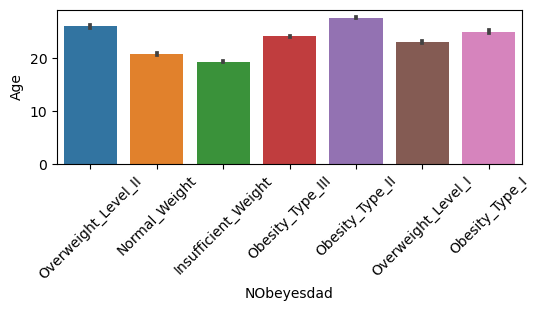

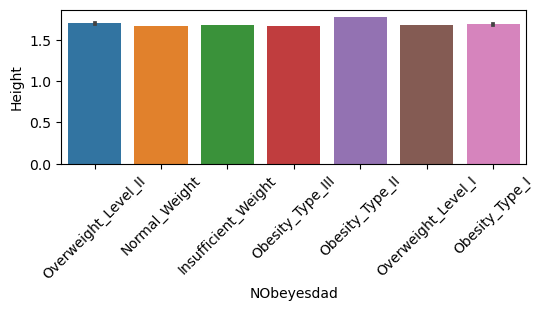

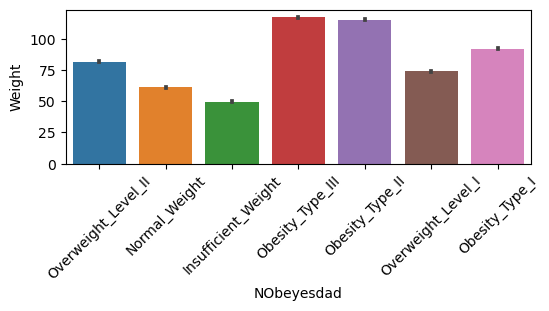

In [298]:
for i in var_cont:
    if i !="id":
        plt.figure(figsize=(6,2))
        ax = sns.barplot(y=i, x="NObeyesdad", data=df)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
        plt.show()

#### Test ANOVA :
- Pour rappel, lorsqu'une variable prends plus de **deux modalités** un test ANOVA est effectué

In [299]:
def anova_test(var_qualitative, var_continues, dataframe):
    var_a_conserver = []
    var_a_supprimer = []

    for col in var_continues: #on parcours les variables continues
        #on  Sépare les données en fonction des différentes valeurs prises par la variable qualitatives
        grouped_data = [
            dataframe.loc[dataframe[var_qualitative] == category, col] for category in dataframe[var_qualitative].unique()
        ]

        # Effectuer le test ANOVA
        statistic, p_value = f_oneway(*grouped_data)

        # Interprétation du résultat
        if p_value < 0.05:
            var_a_conserver.append(col)
        else:
            var_a_supprimer.append(col)

    return var_a_conserver, var_a_supprimer


In [300]:
var_a_conserver, var_a_supprimer = anova_test("NObeyesdad", var_cont, df)

print("Variables à conserver :", var_a_conserver)
print("Variables à supprimer :", var_a_supprimer)

Variables à conserver : ['id', 'Age', 'Height', 'Weight']
Variables à supprimer : []


### Conclusion de la partie test statistique : 
On conserve l'entièreté des variables

In [301]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2,3,Sometimes,no,3,no,0,1,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2,3,Frequently,no,2,no,1,1,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,2,1,Sometimes,no,2,no,1,2,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,3,2,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Overweight_Level_II


## 5. Analyse multivariée :

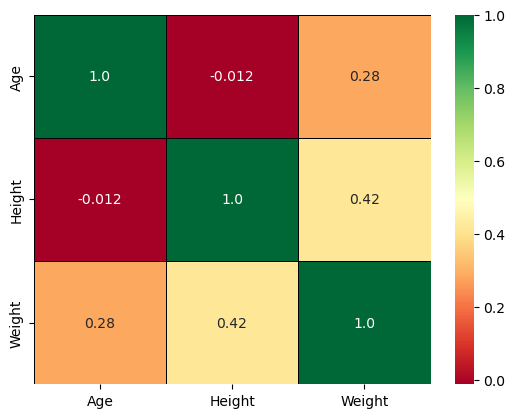

In [302]:
sns.heatmap(df[var_cont[1:]].corr(), fmt=".2", annot = True, cmap = "RdYlGn", linecolor="black", linewidths=0.5)
plt.show()

### Observation : 
- Il y a une corrélation linéaire pour les features Age et Weight et Height Weight

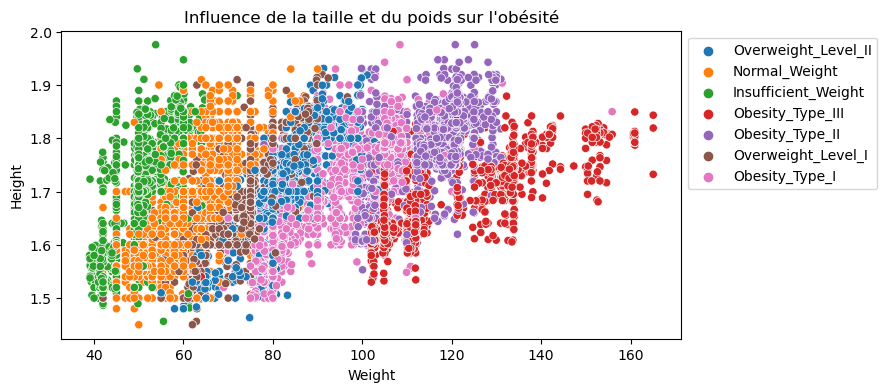

In [303]:
plt.figure(figsize=(8,4))

plt.title("Influence de la taille et du poids sur l'obésité")
sns.scatterplot( y ="Height", x = "Weight" , data=df, hue = "NObeyesdad")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Plus une personne est lourde et plus elle est atteint d'obésité sévère, à l'inverse, on voit qu'on a aussi dans les patients, des personnes n'ayant pas

# 6. Preprocessing 

### Standardisation :
- Standardisation des données 
On va réduire et centrées les variables continues

In [304]:
### Séparation des données : 
X = df.drop('NObeyesdad', axis = 1)
y = df["NObeyesdad"]
X_train,X_test, y_train,y_test = train_test_split(X,y, random_state=42)

In [305]:
#Retirons id de var_cont 
var_cont.remove("id")
var_ord.remove("NObeyesdad")


In [306]:
scaler = StandardScaler()
scaler.fit(X_train[var_cont])
X_train[var_cont] = scaler.transform(X_train[var_cont])
X_test[var_cont] = scaler.transform(X_test[var_cont])

##### Enregistrement du Standarscaler entrainé :

In [307]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


### Encodages:
##### - Variables nominales
Ici nous n'avons qu'une seule variable nominale, nous allons lui faire subir un OneHotEncoder avec **LabelBinarizer**

In [308]:
# Créer une instance de OneHotEncoder
ohe = LabelBinarizer()

In [309]:
ohe.fit(Xtrain[var_nom])

LabelBinarizer()

##### Enregistrement du onehotencoder entrainé :

In [310]:
with open('ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)

Transformation des nouvelles données : 

In [311]:
X_train_ohe = ohe.transform(X_train[var_nom])
X_test_ohe = ohe.transform(X_test[var_nom])

Mettre les nouvelles données sous forme de dataframe :

In [312]:
X_train_ohe_df = pd.DataFrame(data = X_train_ohe, columns=ohe.classes_, index = X_train.index)
X_test_ohe_df = pd.DataFrame(data = X_test_ohe, columns=ohe.classes_, index = X_test.index)

Supprimer l'ancienne colonne de var_nom du X_train et X_test pour remplacer par les nouvelles colonnes :

In [313]:
X_train.drop(var_nom, axis = 1, inplace=True)
X_test.drop(var_nom, axis = 1, inplace=True)

In [314]:
X_train = pd.concat([X_train, X_train_ohe_df], axis = 1)
X_test = pd.concat([X_test, X_test_ohe_df], axis = 1)

- **Variables ordinales**

Les variables ordinales (et binaire aussi) vont être encodé via en LabelEncoder


In [315]:
ordinalencoder = OrdinalEncoder(handle_unknown="use_encoded_value", #les parametres ici signifie que si l'ordinal encoder
                                unknown_value=-1)#rencontre des valeurs non présente durant la phase d'entrainement
                                                #il remplacera par l'encodage de la valeur attribué (ici -1)
#En effet, sur le notebook 03_soumission_modele nous rencontrons des valeurs qui n'étaient pas présent durant cette phase
#d'entrainement (colonne CALC, valeurs "Always" présente 2 fois)
ordinalencoder.fit(X_train[var_ord])
X_train[var_ord] = ordinalencoder.transform(X_train[var_ord])
X_test[var_ord] = ordinalencoder.transform(X_test[var_ord])

##### Enregistrement du OrdinalEncoder entrainé :

In [316]:
with open('ordinalencoder.pkl', 'wb') as f:
    pickle.dump(ordinalencoder, f)

### Fusion des données et formation du dataset final :

In [317]:
#Fusion features-target pour le train et test set :
train_set = pd.concat([X_train,y_train],axis = 1)
test_set = pd.concat([X_test,y_test],axis = 1)

In [318]:
#concaténation du train et test set :
final_df = pd.concat([train_set,test_set])

In [319]:
#Remettre le jeu de données dans l'ordre d'origine :
final_df = final_df.sort_values(by="id")

In [320]:
path_csv = "D:\\etude_data_science\\Kaggle_competition\\03_Multi-Class Prediction of Obesity Risk\\dataset\\"
final_df.to_csv(path_csv+"final_df.csv",index=False)